In [1]:
import pandas as pd
import numpy as np
import pickle
from keras.models import load_model
from adjustText import adjust_text

from models_utils import cats2ints, cats2ints_transform, E_MNL_train, EL_MNL_train, model_load_and_predict, model_predict
from models import E_MNL, EL_MNL
from post_estimation_stats import create_index, get_betas_and_embeddings, get_inverse_Hessian, get_stds, model_summary


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load the data and prepare model input

Load the swissmetro training and test set (same partition as in [Sifringer et al. (2020)](https://www.researchgate.net/publication/344428513_Enhancing_discrete_choice_models_with_representation_learning) for comparability of the results). 

> The variables in X are saved in an numpy array of shape (n_obs, n_variables, n_choices, 1) and can be used directly as an input to the E-MNL and EL-MNL models.

> The categorical variables in Q are saved to a .csv file of shape (n_obs, n_variables) with the variable names as columns and the categorical values as rows in string format. In order to be used as an input to the E-MNL and EL-MNL models, strings will have to be mapped to integers.


In [2]:
# Load the training data:
with open('X_TRAIN.pkl', 'rb') as fp:
    X_TRAIN= pickle.load(fp)
    
Q_df_TRAIN= pd.read_csv('Q_train.csv')

with open('y_TRAIN.pkl', 'rb') as fp:
    y_TRAIN= pickle.load(fp)
    
# Load the test data:
with open('X_TEST.pkl', 'rb') as fp:
    X_TEST= pickle.load(fp)

Q_df_TEST= pd.read_csv('Q_test.csv')

with open('y_TEST.pkl', 'rb') as fp:
    y_TEST= pickle.load(fp)

In [3]:
# Continuous variables (X) (plus intercepts)
X_vars=[ 'ASC_Car', 
         'ASC_SM',
         'TT_SCALED(/100)',
         'COST_SCALED(/100)',
         'Headway_Train_SM']

# Categorical variables (Q) to be encoded as embeddings
Q_vars= ['PURPOSE', 'FIRST', 'TICKET', 'WHO',
           'LUGGAGE', 'AGE', 'MALE', 'INCOME',
           'GA', 'ORIGIN', 'DEST', 'SM_SEATS']


In [4]:
X_TRAIN.shape

(7234, 5, 3, 1)

In [5]:
Q_df_TRAIN.head()

,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,MALE,INCOME,GA,ORIGIN,DEST,SM_SEATS
0,FromWork,no_1stClass,2way_1/2,half-half,1_piece,39<age≤54,male,50≤inc≤100,no_GA,O_BE,D_ZH,Airline_seats
1,FromBusiness,no_1stClass,2way_1/2,self,1_piece,age≤24,female,under50,no_GA,O_TH,D_AG,Airline_seats
2,Leisure,1stClass,Annual,self,NO_luggage,39<age≤54,female,50≤inc≤100,no_GA,O_GE,D_VS,NO_Airline_seats
3,Business,no_1stClass,Annual,employer,1_piece,39<age≤54,female,over100,GA,O_VD,D_BE,NO_Airline_seats
4,Business,no_1stClass,2way_1/2,employer,NO_luggage,24<age≤39,female,50≤inc≤100,no_GA,O_ZH,D_SG,NO_Airline_seats


In [6]:
NUM_OBS_TRAIN= X_TRAIN.shape[0]
NUM_OBS_TEST= X_TEST.shape[0]

NUM_CHOICES= X_TRAIN.shape[2]
NUM_X_VARS= X_TRAIN.shape[1]
NUM_Q_VARS= Q_df_TRAIN.shape[-1]

UNIQUE_CATS= sorted(list(set(Q_df_TRAIN.values.reshape(-1))))
NUM_UNIQUE_CATS= len(UNIQUE_CATS)

print('The number of alternatives (C) is:',NUM_CHOICES)
print('The number of continuous variables (|X|) is:', NUM_X_VARS)
print('The number of categorical variables (|Q|) to be encoded as embeddings is:', NUM_Q_VARS)
print('The number of unique categories in Q (Z) is:', NUM_UNIQUE_CATS)
print()
print('The number of observations in the training set is:', NUM_OBS_TRAIN)
print('The number of observations in the test set is:', NUM_OBS_TEST)

The number of alternatives (C) is: 3
The number of continuous variables (|X|) is: 5
The number of categorical variables (|Q|) to be encoded as embeddings is: 12
The number of unique categories in Q (Z) is: 81

The number of observations in the training set is: 7234
The number of observations in the test set is: 1802


Map categories (strings) in Q to integers for model input:
*We note that this mapping is equivalent to one-hot encoding as each category is represented as a numerical index. One-hot encoding is a binary vector representation of categorical data with 1 appearing where the vector index is equal to the value being encoded and 0 where it is not*
> (Note: to avoid inconsistencies between training and test data transformation, the categories to integers mapping should be based on the training data)

In [7]:
cats2ints_mapping= cats2ints(Q_df_TRAIN)

print(cats2ints_mapping)

{'1/2day': 0, '1_piece': 1, '1stClass': 2, '1way': 3, '1way_1/2': 4, '24<age≤39': 5, '2way': 6, '2way_1/2': 7, '39<age≤54': 8, '50≤inc≤100': 9, '54<age≤ 65': 10, '65 <age': 11, 'Airline_seats': 12, 'Annual': 13, 'Annual_Junior_Senior': 14, 'Business': 15, 'Commuter': 16, 'D_AG': 17, 'D_AI': 18, 'D_AR': 19, 'D_BE': 20, 'D_BL': 21, 'D_BS': 22, 'D_FR': 23, 'D_GE': 24, 'D_GR': 25, 'D_JU': 26, 'D_LU': 27, 'D_SG': 28, 'D_SH': 29, 'D_SO': 30, 'D_SZ': 31, 'D_TH': 32, 'D_TI': 33, 'D_VD': 34, 'D_VS': 35, 'D_ZG': 36, 'D_ZH': 37, 'Free_after_7pm': 38, 'FromBusiness': 39, 'FromLeisure': 40, 'FromShopping': 41, 'FromWork': 42, 'GA': 43, 'Leisure': 44, 'NO_Airline_seats ': 45, 'NO_luggage': 46, 'O_AG': 47, 'O_AR': 48, 'O_BE': 49, 'O_BS': 50, 'O_FR': 51, 'O_GE': 52, 'O_GL': 53, 'O_GR': 54, 'O_LU': 55, 'O_SG': 56, 'O_SH': 57, 'O_SZ': 58, 'O_TH': 59, 'O_TI': 60, 'O_VD': 61, 'O_VS': 62, 'O_ZG': 63, 'O_ZH': 64, 'Other': 65, 'Other_purp': 66, 'Shopping': 67, 'age≤24': 68, 'employer': 69, 'female': 70, 'hal

Transform strings to integers in training and test Q data:

In [8]:
Q_TRAIN= cats2ints_transform(Q_df_TRAIN, cats2ints_mapping)
Q_TEST= cats2ints_transform(Q_df_TEST, cats2ints_mapping)

print(Q_TRAIN)
print(Q_TRAIN.shape) #(n_obs, n_variables in Q)

[[42 73  7 ... 49 37 12]
 [39 73  7 ... 59 17 12]
 [44  2 13 ... 52 35 45]
 ...
 [15 73 13 ... 49 37 12]
 [44  2 14 ... 49 32 45]
 [44 73  6 ... 52 25 45]]
(7234, 12)


# Train the models and predict on (the training) and the test data:

> (You can [Use GPU](https://www.tensorflow.org/guide/gpu) to accelarate computations!)

### Train the E-MNL model:

> The number of training epochs is set to 500 but the model converges before that (around 400 epochs) and stops training any further.

In [9]:
# Train and save the E-MNL model - uncomment the following lines to train the model from scratch
# -To deactivate verbose output set VERBOSE= 0 (VERBOSE= 1 by default)-

# trained_emnl= E_MNL_train(X_TRAIN, Q_TRAIN, y_TRAIN, 
#                           N_EPOCHS=500, model_filename='name_your_model')

In [10]:
# Or Load a model that is trained and saved
trained_emnl= load_model('EMNL_model') 

Compute  LL on the training data:

In [11]:
# Use the trained E-MNL  model to predict on training data and compute LL:
LL_train= model_predict(X_TRAIN, Q_TRAIN, y_TRAIN, trained_emnl)
print('LL_train: ', LL_train)

# (Or load the saved model and do the same):
LL_train= model_load_and_predict(X_TRAIN, Q_TRAIN, y_TRAIN,  model_filename= 'EMNL_model')


LL_train:  -4912.474119881059


Compute  LL on the test data:

In [12]:
# Use the trained E-MNL  model to predict on test data and compute LL:
LL_test= model_predict(X_TEST, Q_TEST, y_TEST, trained_emnl)
print('LL_test: ', LL_test)

# (Or load the saved model and do the same):
LL_test= model_load_and_predict(X_TEST, Q_TEST, y_TEST, model_filename= 'EMNL_model')

LL_test:  -1230.2205843340898


### Train the EL-MNL model:

In [13]:
# Train and save the EL-MNL model - uncomment the following lines to train the model from scratch
# -To deactivate verbose output set VERBOSE= 0 (VERBOSE= 1 by default)-

# trained_elmnl= EL_MNL_train(X_TRAIN, Q_TRAIN, y_TRAIN,
#                             n_extra_emb_dims=2, 
#                             N_NODES=15, N_EPOCHS=500,
#                             model_filename='name_your_model')

In [14]:
trained_elmnl= load_model('ELMNL_model') #Load a saved model

Compute  LL on the training data:

In [15]:
# Use the trained EL-MNL  model to predict on training data and compute LL:
LL_train= model_predict(X_TRAIN, Q_TRAIN, y_TRAIN, trained_elmnl)
print('LL_train: ', LL_train)

# (Or load the saved model and do the same):
LL_train= model_load_and_predict(X_TRAIN, Q_TRAIN, y_TRAIN,  model_filename= 'ELMNL_model')


LL_train:  -4003.610635592916


 Compute the LL on the test data:

In [16]:
# Use the trained EL-MNL  model to predict on test data and compute LL:
LL_test= model_predict(X_TEST, Q_TEST, y_TEST, trained_elmnl)
print('LL_test: ', LL_test)

# (Or load the saved model and do the same):
LL_test= model_load_and_predict(X_TEST, Q_TEST, y_TEST, model_filename= 'ELMNL_model')

LL_test:  -1070.5644412492484


# Compute post-estimation statistics

Get E-MNL model summary statistics:

In [17]:
stats_EMNL= model_summary(trained_emnl, X_TRAIN, Q_TRAIN, y_TRAIN,
                          X_vars_names= X_vars, Q_vars_names= Q_vars)
stats_EMNL

,Betas,St errors,t-stat,p-value
ASC_Car,0.244234,0.092813,2.631466,0.0085
ASC_SM,0.471381,0.079049,5.963130,0.0000
TT_SCALED(/100),-1.542901,0.053990,-28.577317,0.0000
COST_SCALED(/100),-1.132705,0.043197,-26.222101,0.0000
Headway_Train_SM,-0.807452,0.121743,-6.632427,0.0000
PURPOSE,13.927765,1.047881,13.291365,0.0000
FIRST,2.008403,1.194204,1.681791,0.0926
TICKET,13.435410,0.693057,19.385734,0.0000
WHO,8.498120,1.482708,5.731487,0.0000
LUGGAGE,6.517580,2.018969,3.228172,0.0012


Get EL-MNL model summary statistics:

In [18]:
stats_ELMNL= model_summary(trained_elmnl, X_TRAIN, Q_TRAIN, y_TRAIN,
                          X_vars_names= X_vars, Q_vars_names= Q_vars)
stats_ELMNL

,Betas,St errors,t-stat,p-value
ASC_Car,-0.465026,0.099888,-4.655482,0.0000
ASC_SM,0.037956,0.083851,0.452658,0.6508
TT_SCALED(/100),-1.911129,0.056154,-34.033619,0.0000
COST_SCALED(/100),-1.921355,0.052611,-36.519808,0.0000
Headway_Train_SM,-0.898933,0.131160,-6.853707,0.0000
PURPOSE,10.126370,2.164007,4.679455,0.0000
FIRST,3.265503,0.904189,3.611525,0.0003
TICKET,14.693038,1.764101,8.328910,0.0000
WHO,8.542205,1.748995,4.884065,0.0000
LUGGAGE,6.317420,3.933461,1.606072,0.1083


# Extract betas end embedding values from the trained models

In [19]:
EMNL_dict= get_betas_and_embeddings(trained_emnl, Q_df_TRAIN)

ELMNL_dict= get_betas_and_embeddings(trained_elmnl, Q_df_TRAIN)

print(ELMNL_dict.keys())
print()

cats2embs= dict(zip(cats2ints_mapping.keys(),ELMNL_dict['embeddings']))
x_vars_betas= dict(zip(X_vars, ELMNL_dict['betas_exog']))
q_vars_betas= dict(zip(Q_vars, ELMNL_dict['betas_embs']))
                
print('Betas for X variables:', x_vars_betas)
print()
print('Betas for Q variables:', q_vars_betas)
print()
print('Embeddings for categories in Q: ', cats2embs )

dict_keys(['index2alfa_from', 'alfa2index_from', 'embeddings', 'betas_embs', 'betas_exog'])

Betas for X variables: {'ASC_Car': -0.46502632, 'ASC_SM': 0.03795578, 'TT_SCALED(/100)': -1.9111294, 'COST_SCALED(/100)': -1.9213555, 'Headway_Train_SM': -0.8989331}

Betas for Q variables: {'PURPOSE': 10.12637, 'FIRST': 3.265503, 'TICKET': 14.693038, 'WHO': 8.542205, 'LUGGAGE': 6.31742, 'AGE': 7.075873, 'MALE': 2.2190957, 'INCOME': 7.137259, 'GA': 2.1670673, 'ORIGIN': 16.573372, 'DEST': 17.195992, 'SM_SEATS': 1.2078309}

Embeddings for categories in Q:  {'1/2day': array([ 0.0553598 , -0.02494151, -0.02037917,  0.01017763,  0.00181075],
      dtype=float32), '1_piece': array([ 0.00366633,  0.00039575, -0.00034975,  0.00481625, -0.00493152],
      dtype=float32), '1stClass': array([-0.01558887,  0.01353349, -0.01616586, -0.06067944, -0.05806037],
      dtype=float32), '1way': array([-0.00944899,  0.03550634, -0.04488284, -0.0625351 ,  0.02663676],
      dtype=float32), '1way_1/2': array([-0.0208

# Visualize Interpretable Embeddings Dimensions
> (Below we visualize the interpretable embeddings generated by the EL-MNL model. The same process can be followed for the E-MNL generated embeddings )

Visualize embedding space per variable:

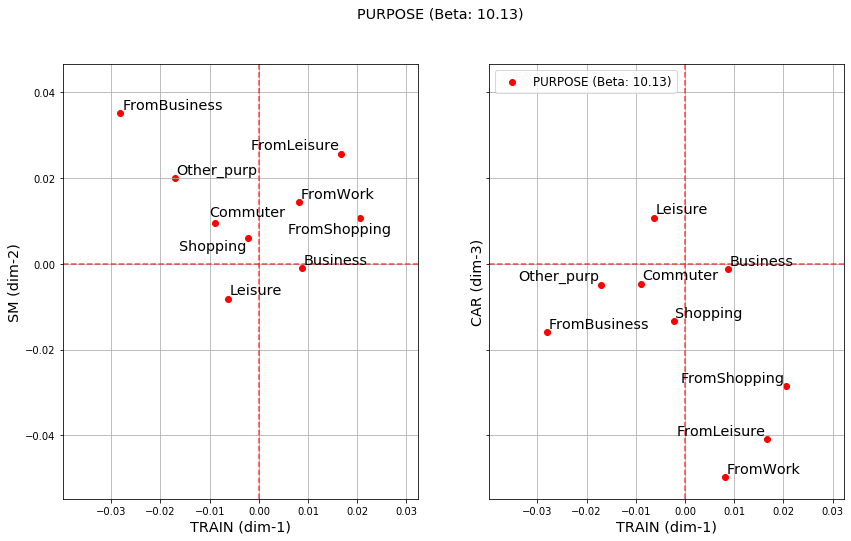

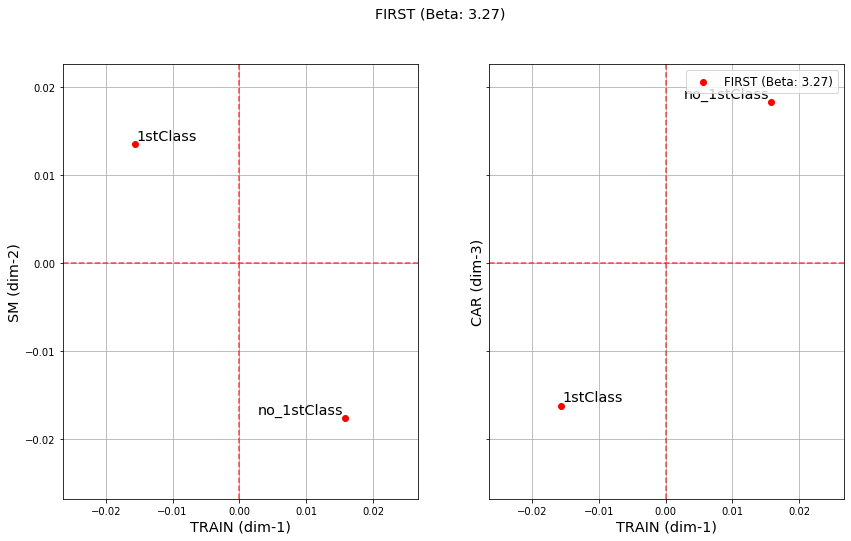

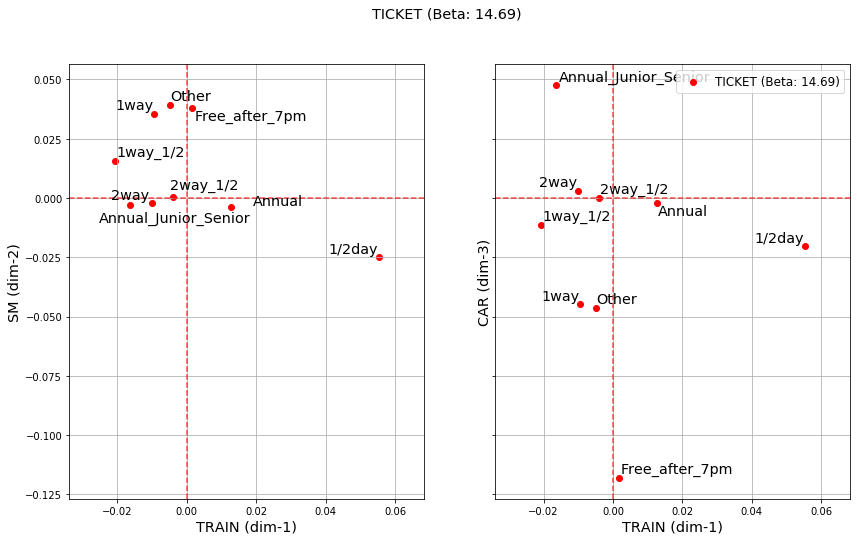

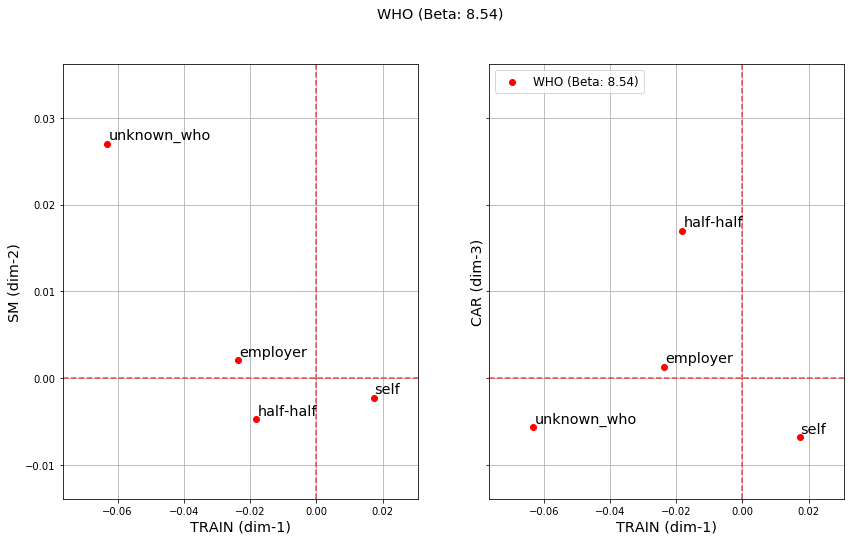

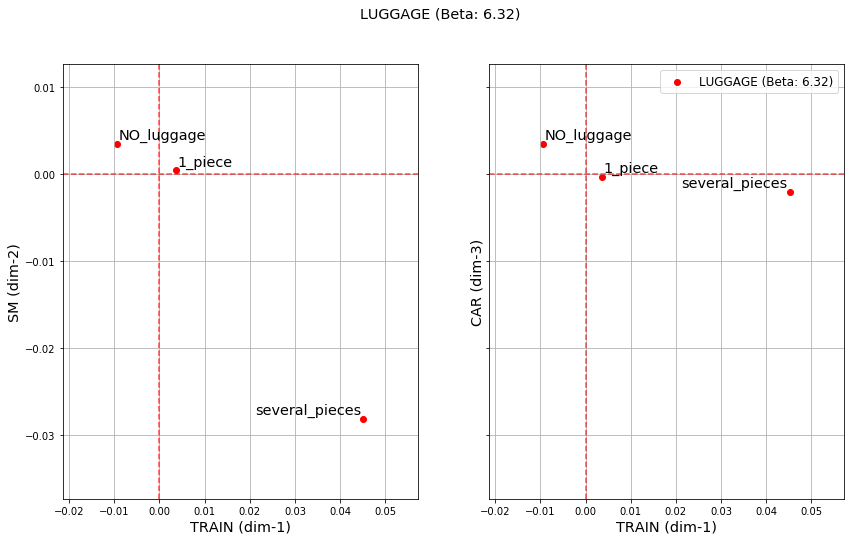

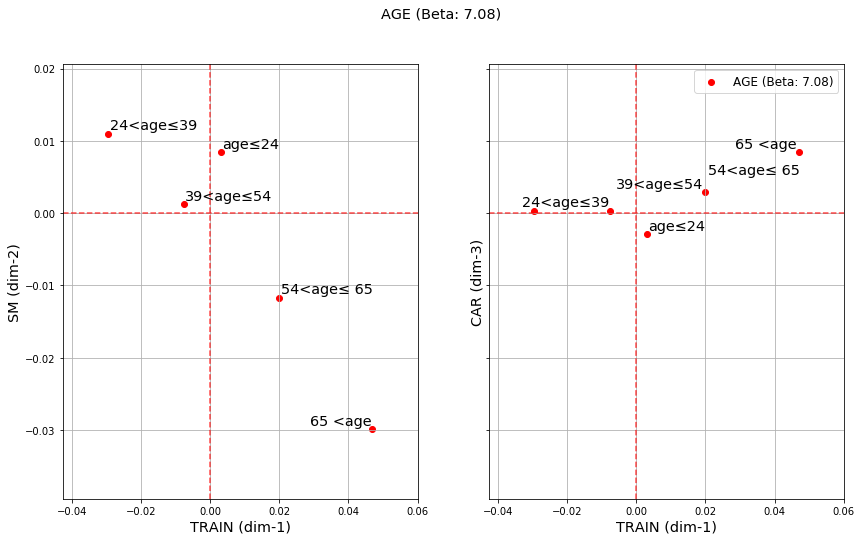

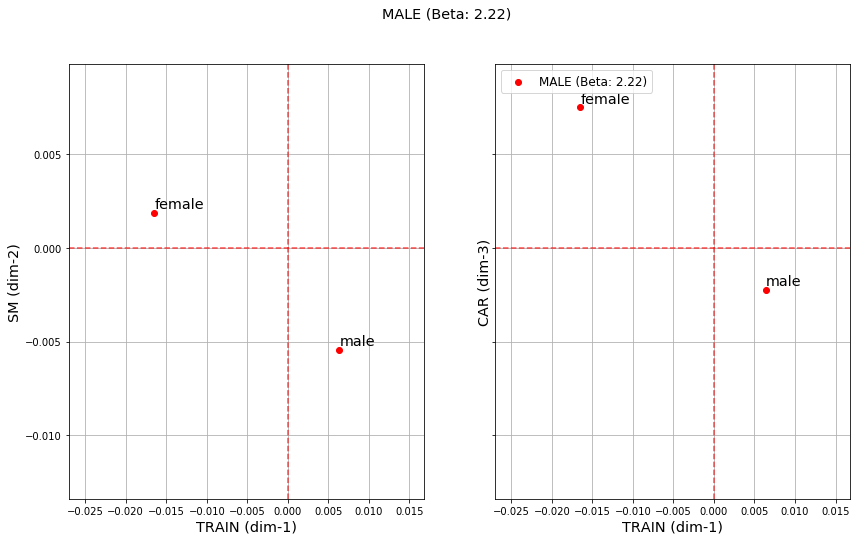

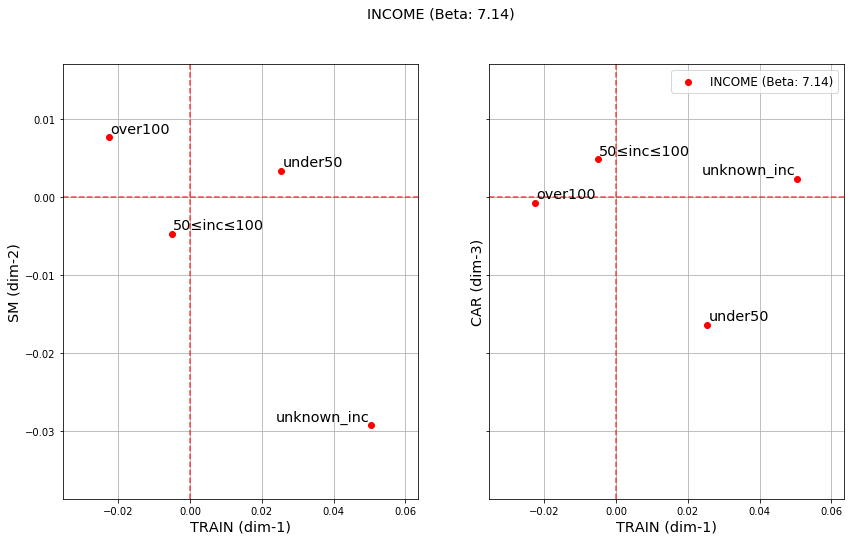

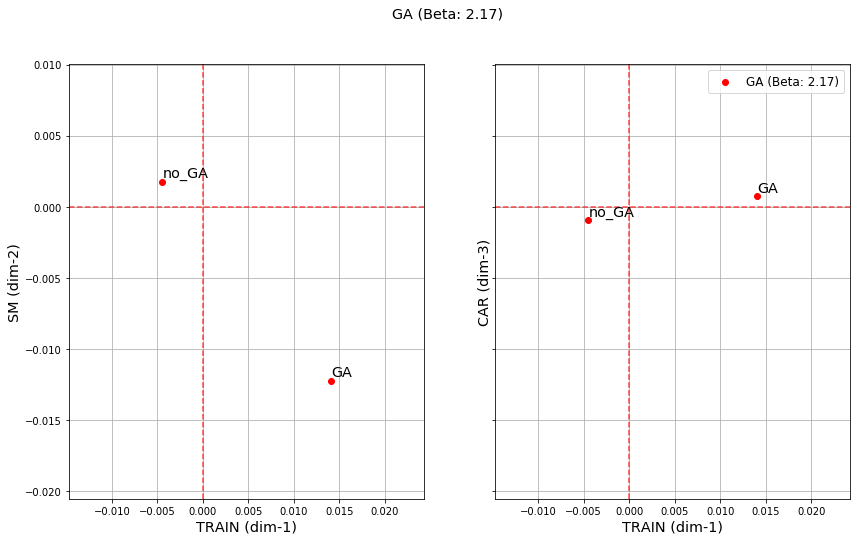

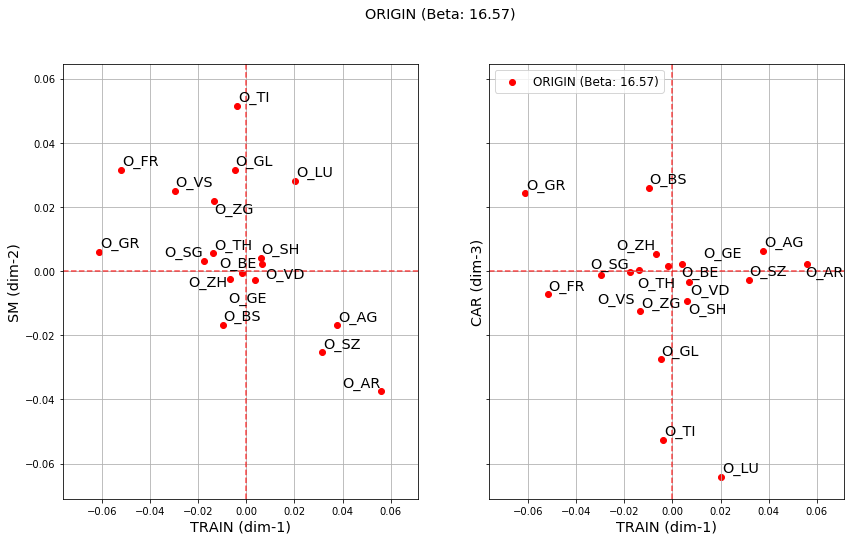

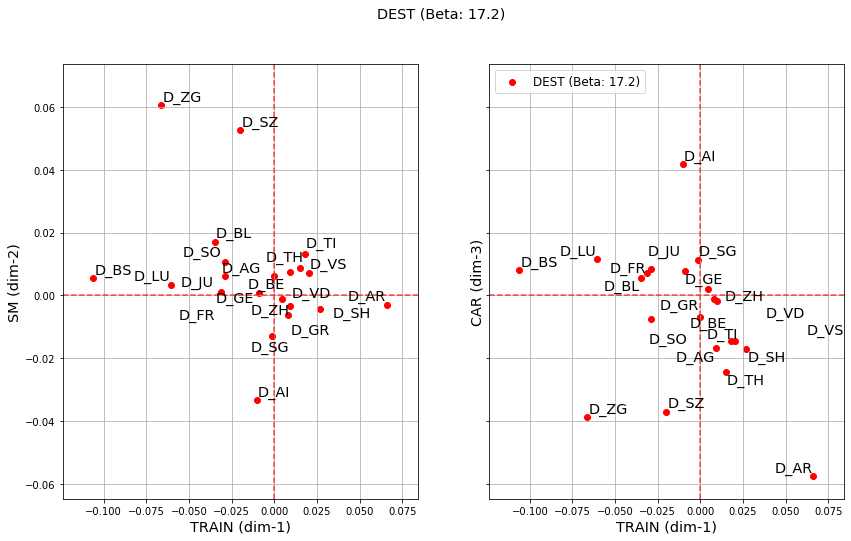

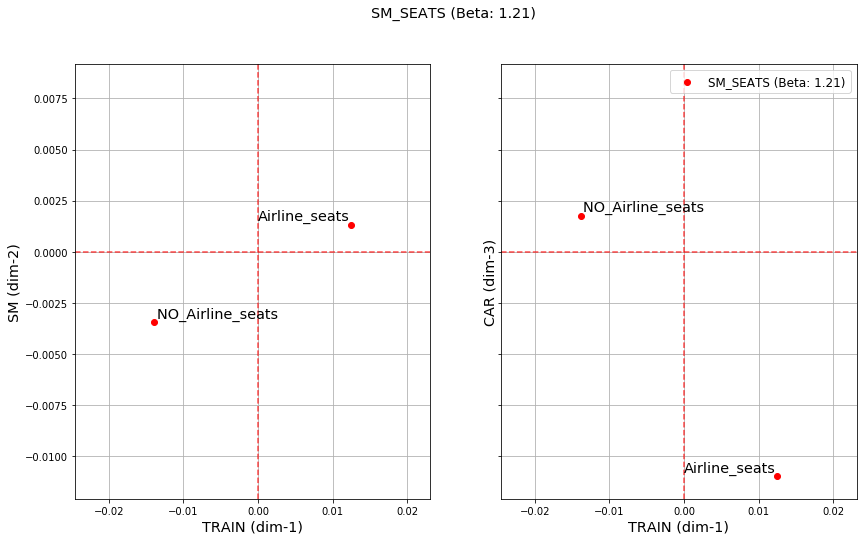

In [20]:
# create a dictionary that maps the Q variables to their corresponding categories
vars_cats={col:sorted(set(Q_df_TRAIN[col])) for col in Q_df_TRAIN.columns}

for var,cats in vars_cats.items():
    
    beta= q_vars_betas[var]
    #color= colors[idx]
    
    embs=[]
        
    for cat in cats:
        embs.append(cats2embs[cat][:NUM_CHOICES])

    embs=np.array(embs)#*beta
    fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,sharey=True, figsize=(14,8))
    
    fig.suptitle(var+' (Beta: '+ str(np.round(beta,2))+')',fontsize='x-large')

    ax1.axhline(0, color='red', linestyle='--',alpha=0.7)
    ax2.axhline(0, color='red', linestyle='--',alpha=0.7)
    ax1.axvline(0, color='red', linestyle='--',alpha=0.7)
    ax2.axvline(0, color='red', linestyle='--',alpha=0.7)
    
    texts = [ax1.text(embs[i,0], embs[i,1], cats[i],fontsize='x-large') for i in range(len(cats))]
    texts2 = [ax2.text(embs[i,0], embs[i,2], cats[i],fontsize='x-large') for i in range(len(cats))]
    
    print()
    ax1.scatter(embs.T[0], embs.T[1], c='r',label=var +' (Beta: '+ str(np.round(beta,2))+')')#list_betas_embs[idx] )
    ax2.scatter(embs.T[0], embs.T[2], c='r',label=var +' (Beta: '+ str(np.round(beta,2))+')')#list_betas_embs[idx] )
   
    ax1.set_xlabel(xlabel='TRAIN (dim-1)', fontsize='x-large')
    ax1.set_ylabel(ylabel='SM (dim-2)', fontsize='x-large')
    ax2.set_xlabel(xlabel='TRAIN (dim-1)', fontsize='x-large')
    ax2.set_ylabel(ylabel='CAR (dim-3)', fontsize='x-large')
    ax1.grid()
    ax2.grid()

    adjust_text(texts, ax=ax1)
    adjust_text(texts2, ax=ax2)
    plt.legend(fontsize='large', loc='best')
    
    plt.show()

Common space visualization across all variables in Q (beta scaled values):
> (Note: ORIGIN and DEST variables were excluded from the visualization to avoid cluttering)

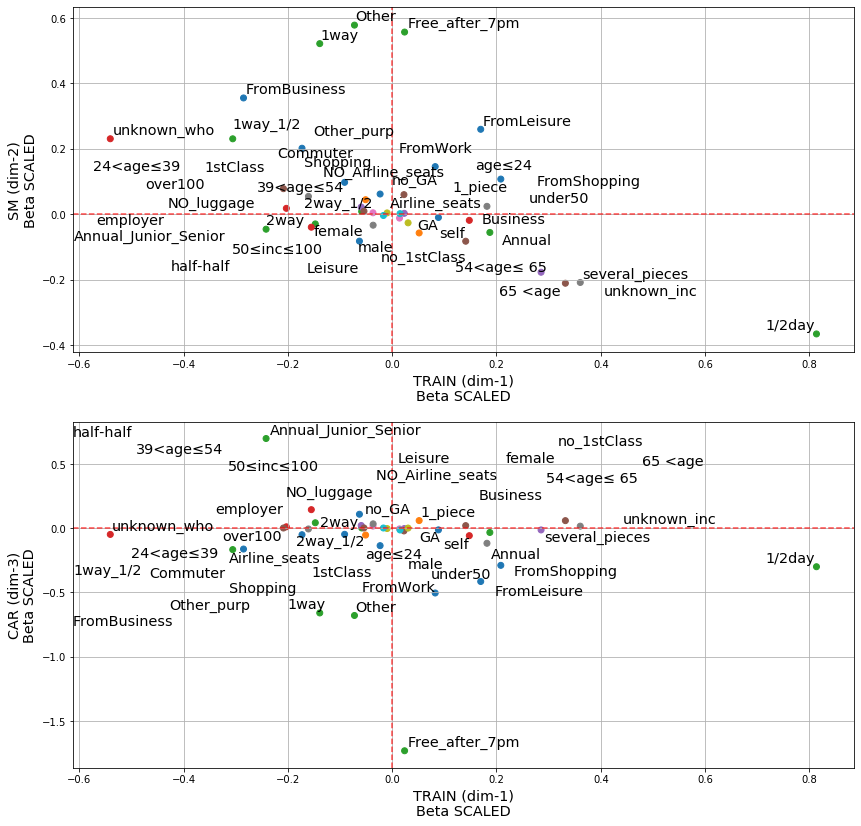

In [21]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

all_colors=[]
all_embs=[]
all_cats=[]
all_vars=[]

fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(14,14))
c=0

for var,cats in vars_cats.items():
    
    if var not in ['ORIGIN', 'DEST']:
        
        color= cycle[c]
        c+=1
        all_vars.append(var)
        beta= q_vars_betas[var]
   
        for cat in cats:
            
            all_colors.append(color)
            all_embs.append(cats2embs[cat][:NUM_CHOICES]*beta)
            all_cats.append(cat)
        
all_embs=np.array(all_embs)
                
ax1.axhline(0, color='red', linestyle='--', alpha=0.7)
ax2.axhline(0, color='red', linestyle='--', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', alpha=0.7)

ax1.scatter(all_embs.T[0], all_embs.T[1],c=all_colors)
ax2.scatter(all_embs.T[0], all_embs.T[2],c=all_colors)
texts1 = [ax1.text(all_embs[i,0], all_embs[i,1],
                   all_cats[i],fontsize='x-large') for i in range(len(all_cats))]
texts2 = [ax2.text(all_embs[i,0], all_embs[i,2],
                   all_cats[i],fontsize='x-large') for i in range(len(all_cats))]

ax1.set_xlabel(xlabel='TRAIN (dim-1)\nBeta SCALED', fontsize='x-large')
ax1.set_ylabel(ylabel='SM (dim-2)\nBeta SCALED', fontsize='x-large')
ax2.set_xlabel(xlabel='TRAIN (dim-1)\nBeta SCALED', fontsize='x-large')
ax2.set_ylabel(ylabel='CAR (dim-3)\nBeta SCALED', fontsize='x-large') 
ax1.grid()
ax2.grid()

adjust_text(texts1, ax=ax1)
adjust_text(texts2, ax=ax2)

plt.show()